In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# and also the exact duplicates
with open("SOME_DATA_DIR/nrep_aucs_gptneo1B_exactduplicates_lr2e5.pickle", "rb") as f:
   nrep_aucs = pickle.load(f)

In [3]:
def compute_rho(phi_fuz: float, phi_exact: dict):

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        return lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
    
    # then if the target is larger than the larger for exact
    elif phi_fuz >= phi_exact[max_key]:
        lambda_ = max_key
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
        
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1,max(nrep_aucs.keys())+1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

## Let's first get the smoothed curve

In [4]:
all_mias = ('loss', 'ratio', 'lowercase', 'minkprob', 'zlib')

all_phi_exact = dict()

for mia in all_mias:
    all_phi_exact[mia] = smooth_curve(nrep_aucs, mia=mia, window_size=3)

In [5]:
smooth_curve(nrep_aucs, mia=mia, window_size=3)

{1: np.float64(0.620688),
 2: np.float64(0.6909693333333333),
 3: np.float64(0.7522146666666667),
 4: np.float64(0.7912226666666666),
 5: np.float64(0.8269613333333334),
 6: np.float64(0.8505720000000001),
 7: np.float64(0.8761666666666668),
 8: np.float64(0.8881506666666665),
 9: np.float64(0.8983733333333334),
 10: np.float64(0.9059240000000002)}

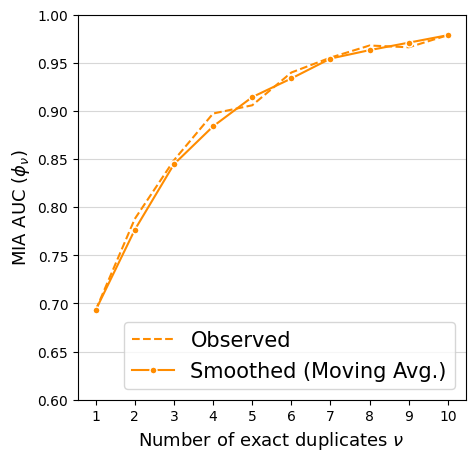

In [6]:
mia = 'ratio'

ns = np.arange(1, 11)  # Number of exact duplicates
observed = [np.mean(nrep_aucs[n][mia]) for n in range(1,max(nrep_aucs.keys())+1)]
smoothed = smooth_curve(nrep_aucs, mia=mia, window_size=3).values()

plt.figure(figsize=(5, 5))
plt.plot(ns, observed, label='Observed', linestyle='--', color = 'darkorange')
plt.plot(ns, smoothed, '-o', label='Smoothed (Moving Avg.)', color = 'darkorange', 
         markersize=5, markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=1)

plt.xlabel(r"Number of exact duplicates $\nu$", fontsize = 13)
plt.ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize = 13)
plt.xticks(ns)
plt.yticks(np.linspace(0.60, 1.00, 9))
plt.ylim(0.60, 1.00)
plt.legend(fontsize = 15, loc='lower right')
plt.grid(axis='y', alpha=0.5)
plt.show()


In [ ]:
nrep_aucs

defaultdict(dict,
            {1: {'ratio': array([0.6814, 0.6858, 0.6902, 0.6437, 0.6957, 0.8008, 0.672 , 0.7196,
                     0.7077, 0.7059, 0.7017, 0.7068, 0.7171, 0.6575, 0.7363, 0.6773,
                     0.6817, 0.708 , 0.6561, 0.651 , 0.7115, 0.7235, 0.6167, 0.6958,
                     0.6809]),
              'loss': array([0.6005, 0.7192, 0.5977, 0.6035, 0.5852, 0.6473, 0.647 , 0.6435,
                     0.6601, 0.6572, 0.5988, 0.6353, 0.6088, 0.655 , 0.6132, 0.6597,
                     0.5387, 0.6207, 0.6963, 0.6779, 0.6635, 0.6698, 0.6112, 0.6493,
                     0.6067]),
              'lowercase': array([0.5751, 0.5412, 0.6067, 0.5568, 0.612 , 0.6569, 0.5992, 0.5928,
                     0.5978, 0.5828, 0.6278, 0.5653, 0.6634, 0.5983, 0.509 , 0.5727,
                     0.6498, 0.5666, 0.5582, 0.5458, 0.6073, 0.5795, 0.5156, 0.5134,
                     0.5445]),
              'minkprob': array([0.7119, 0.7023, 0.6847, 0.6505, 0.6535, 0.6016, 0.6378, 0.

: 

In [ ]:
# get the near dupls
with open("SOME_DATA_DIR/R_aucs_gptneo1B_nearduplicates_diffindices_topk10_RXX_lr2e5.pickle", "rb") as f:
   R_aucs = pickle.load(f)

In [8]:
for R in R_aucs.keys():
    for mia in all_mias:
        #print(f"T={T}, MIA={mia}, AUC = {T_aucs[T][mia][0]:.2f} ± {T_aucs[T][mia][1]}")
        n_eqs = [compute_rho(phi_fuz=auc, phi_exact=all_phi_exact[mia]) for auc in R_aucs[R][mia]]
        print(f"T={R}, MIA={mia}, rho = {np.mean(n_eqs):.2f} ± {np.std(n_eqs)}")
    print('---')

T=1, MIA=loss, rho = 0.93 ± 0.12812054378200546
T=1, MIA=ratio, rho = 0.92 ± 0.09997713963178544
T=1, MIA=lowercase, rho = 1.35 ± 0.5514807956044443
T=1, MIA=minkprob, rho = 1.14 ± 0.2908294876270688
T=1, MIA=zlib, rho = 1.12 ± 0.2880705591898459
---
T=5, MIA=loss, rho = 0.79 ± 0.16952760696566244
T=5, MIA=ratio, rho = 0.83 ± 0.1338924957412771
T=5, MIA=lowercase, rho = 0.77 ± 0.38496706762705074
T=5, MIA=minkprob, rho = 0.69 ± 0.12982878250082433
T=5, MIA=zlib, rho = 0.82 ± 0.20684626237203277
---
T=10, MIA=loss, rho = 0.63 ± 0.17090317906870295
T=10, MIA=ratio, rho = 0.66 ± 0.11004493066401125
T=10, MIA=lowercase, rho = 0.60 ± 0.3107973815108438
T=10, MIA=minkprob, rho = 0.63 ± 0.2973737349190549
T=10, MIA=zlib, rho = 0.71 ± 0.15393563123234724
---
T=15, MIA=loss, rho = 0.57 ± 0.10509746617962698
T=15, MIA=ratio, rho = 0.59 ± 0.07968071319593499
T=15, MIA=lowercase, rho = 0.51 ± 0.32029215958490503
T=15, MIA=minkprob, rho = 0.59 ± 0.14942170273573893
T=15, MIA=zlib, rho = 0.65 ± 0.13

## Lets do some plotting

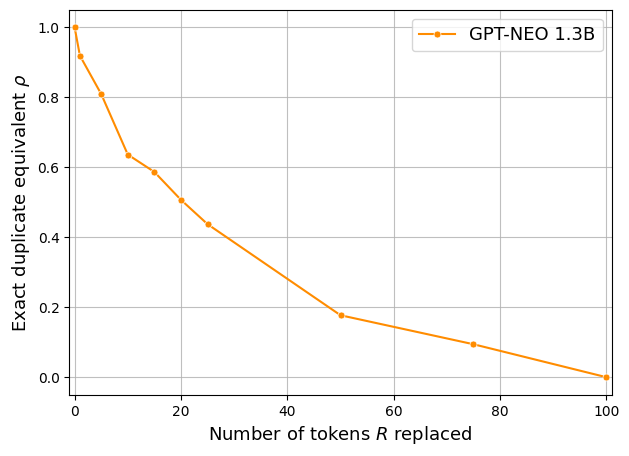

In [9]:
# Let's now plot the equivalent number of repetitions?

all_Rs = [1, 5, 10, 15, 20, 25, 50, 75]

colors = ('darkorange',)
models = ('GPT-NEO 1.3B',)
mia = 'ratio'
    
plt.figure(figsize = (7, 5))

for i in range(len(models)):
    rho_to_plot = dict()
    for R in all_Rs:
        rho_to_plot[R] = compute_rho(phi_fuz=np.mean(R_aucs[R][mia]), phi_exact=all_phi_exact[mia])
            
    plt.plot([0] + all_Rs + [100], [1] + [rho_to_plot[R] for R in all_Rs] + [0], '-o', color=colors[i], markersize=5,
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label = models[i])

plt.xlabel(r'Number of tokens $R$ replaced', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(fontsize = 13, loc='upper right')
plt.grid(alpha = 0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-1, 101)
#plt.yticks([k for k in range(1, 11)])
plt.show()

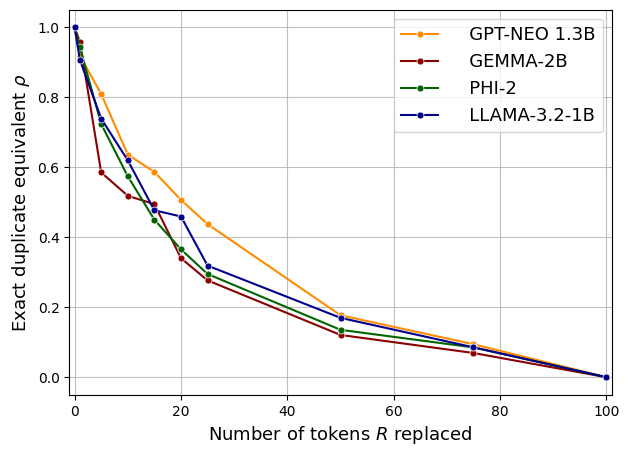

In [ ]:
# can we do this for all models? 

colors = ('darkorange', 'darkred', 'darkgreen', 'darkblue')
models = ('gptneo1B', 'gemma2B', "phi2", "llama3.2_1B")
lrs = ('lr2e5', 'lr1e5', 'lr5e6', 'lr2e6')
labels = ('GPT-NEO 1.3B', 'GEMMA-2B', "PHI-2", "LLAMA-3.2-1B")
results_path = ("")
mia = 'ratio'
    
plt.figure(figsize = (7, 5))

for i in range(len(models)):
    
    # load the exact duplicates results
    with open(f"SOME_DATA_DIR/nrep_aucs_{models[i]}_exactduplicates_{lrs[i]}.pickle", "rb") as f:
       nrep_aucs = pickle.load(f)
       
    # then smooth this
    all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
    # then get the near dupls
    with open(f"SOME_DATA_DIR/R_aucs_{models[i]}_nearduplicates_diffindices_topk10_RXX_{lrs[i]}.pickle", "rb") as f:
       R_aucs = pickle.load(f)
    
    rho_to_plot = dict()
    for R in all_Rs:
        rho_to_plot[R] = compute_rho(phi_fuz=np.mean(R_aucs[R][mia]), phi_exact=all_phi_exact)
            
    plt.plot([0] + all_Rs + [100], [1] + [rho_to_plot[R] for R in all_Rs] + [0], '-o', color=colors[i], markersize=5,
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label = "   " + labels[i])

plt.xlabel(r'Number of tokens $R$ replaced', fontsize = 13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize = 13)
plt.legend(fontsize = 13, loc='upper right')
plt.grid(alpha = 0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-1, 101)
#plt.yticks([k for k in range(1, 11)])
plt.show()

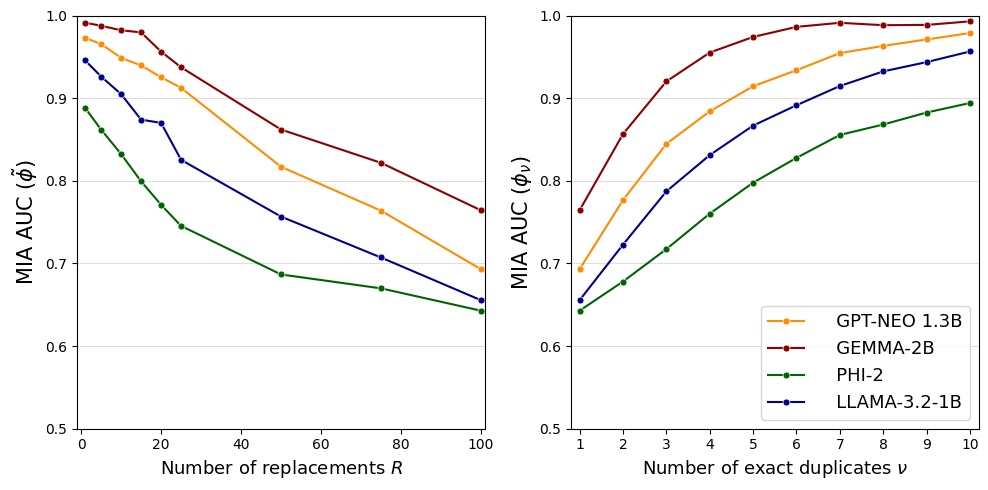

In [ ]:
all_ns = range(1, 11)

# Set the reference R value to link between the two plots
mia = 'ratio'

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


for i in range(len(models)):
    
    # load the exact duplicates results
    with open(f"SOME_DATA_DIR/nrep_aucs_{models[i]}_exactduplicates_{lrs[i]}.pickle", "rb") as f:
       nrep_aucs = pickle.load(f)
       
    # then smooth this
    all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
    # then get the near dupls
    with open(f"SOME_DATA_DIR/R_aucs_{models[i]}_nearduplicates_diffindices_topk10_RXX_{lrs[i]}.pickle", "rb") as f:
       R_aucs = pickle.load(f)
    
    rho_to_plot = dict()
    for R in all_Rs:
        rho_to_plot[R] = compute_rho(phi_fuz=np.mean(R_aucs[R][mia]), phi_exact=all_phi_exact)
            
    ax1.plot(all_Rs + [100], [np.mean(R_aucs[R][mia]) for R in all_Rs] + [all_phi_exact[1]], '-o', color=colors[i], markersize=5,
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label = "   " + labels[i])
    
    ax2.plot(all_ns, [all_phi_exact[nrep] for nrep in all_ns], '-o', color=colors[i], markersize=5,
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5, label = "   " + labels[i])

ax1.set_xlabel(r'Number of replacements $R$', fontsize=13)
ax1.set_ylabel(r"MIA AUC ($\tilde{\phi}$)", fontsize=15)
ax1.grid(axis='y', alpha = 0.4)
ax1.set_ylim(0.5, 1)
ax1.set_xlim(-1, 101)

ax2.set_xlabel(r"Number of exact duplicates $\nu$", fontsize=13)
ax2.set_ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize=15)
ax2.grid(axis='y', alpha = 0.4)
ax2.set_ylim(0.5, 1)
ax2.set_xlim(0.8, 10.2)
ax2.set_xticks(all_ns)

ax2.legend(loc = 'lower right', fontsize = 13)

plt.tight_layout()
plt.show()


## Let's do the main metric figure

In [ ]:
model = 'gptneo1B'
lr = 'lr2e5'

with open(f"SOME_DATA_DIR/nrep_aucs_{model}_exactduplicates_{lr}.pickle", "rb") as f:
    nrep_aucs = pickle.load(f)
       
# then smooth this
all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
# then get the near dupls
with open(f"SOME_DATA_DIR/R_aucs_{model}_nearduplicates_diffindices_topk10_RXX_{lr}.pickle", "rb") as f:
    R_aucs = pickle.load(f)
    
rho_to_plot = dict()
for R in all_Rs:
    rho_to_plot[R] = compute_rho(phi_fuz=np.mean(R_aucs[R][mia]), phi_exact=all_phi_exact)

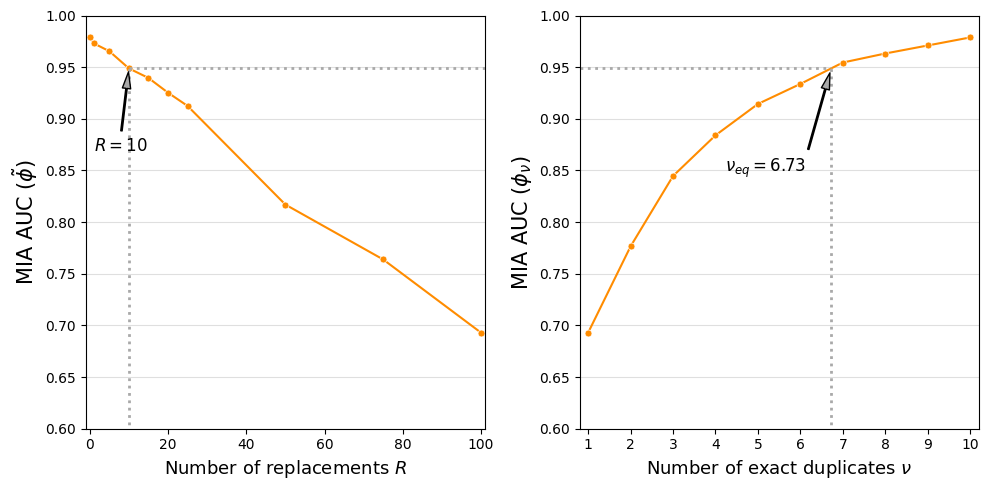

In [45]:
all_ns = range(1, 11)

# Set the reference R value to link between the two plots
mia = 'ratio'
R_value = 10  # You can change this
R_auc_value = np.mean(R_aucs[R_value][mia])  # The AUC at R=10

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ---------- Left plot (R vs AUC) ----------
ax1.plot([0] + all_Rs + [100], [np.mean(nrep_aucs[10][mia])] + [np.mean(R_aucs[R][mia]) for R in all_Rs] + [np.mean(nrep_aucs[1][mia])],
         '-o', color='darkorange', markersize=5, markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=0.5)

ax1.set_xlabel(r'Number of replacements $R$', fontsize=13)
ax1.set_ylabel(r"MIA AUC ($\tilde{\phi}$)", fontsize=15)
ax1.grid(axis='y', alpha = 0.4)
ax1.set_ylim(0.6, 1)
ax1.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ax1.set_xlim(-1, 101)

# Vertical dotted line at R=R_value and horizontal dotted line at the AUC value
#ax1.axvline(R_value, linestyle='dotted', color='red', linewidth=2)
ax1.plot([R_value, R_value], [0.5, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)
ax1.plot([R_value, 101], [R_auc_value, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# ---------- Right plot (n_dup vs AUC) ----------
ax2.plot(all_ns, [all_phi_exact[n] for n in all_ns], '-o', color='darkorange', markersize=5,
         markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=0.5)

ax2.set_xlabel(r"Number of exact duplicates $\nu$", fontsize=13)
ax2.set_ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize=15)
ax2.grid(axis='y', alpha = 0.4)
ax2.set_ylim(0.6, 1)
ax2.set_xlim(0.8, 10.2)
ax2.set_xticks(all_ns)

# Find the closest value of n_dup where the horizontal line intersects the Ratio AUC curve in the right plot
n_eq = rho_to_plot[R_value] * 9 + 1
n_dup_auc_value = R_auc_value

# Horizontal dotted line from left to right plot at AUC value
ax2.plot([0.8, n_eq], [R_auc_value, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# Vertical dotted line at the corresponding n_dup value
ax2.plot([n_eq, n_eq], [0.5, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# Annotating the vertical connections
ax1.annotate(f'$R={R_value}$', xy=(R_value, R_auc_value), xytext=(R_value - 9, R_auc_value - 0.08),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))
ax2.annotate(rf'$\nu_{{eq}}={n_eq:.2f}$', xy=(n_eq, R_auc_value), xytext=(n_eq - 2.5, R_auc_value - 0.1),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))

#plt.suptitle(f"10 fuzzy duplicates are memorized as much as {n_eq:.2f} exact duplicates", fontsize = 14)

# Adjust the layout
plt.tight_layout()
#plt.savefig('./metric_figure.pdf', bbox_inches='tight')
plt.show()


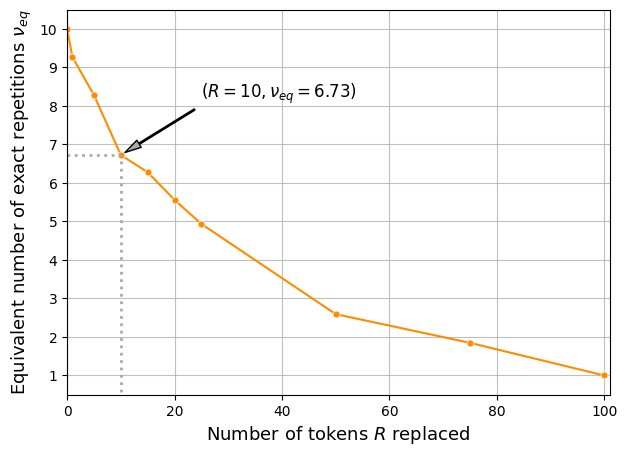

In [58]:
# Let's now plot the equivalent number of repetitions?
    
plt.figure(figsize = (7, 5))

plt.plot([0] + all_Rs + [100], [10] + [rho_to_plot[R] * 9 + 1 for R in all_Rs] + [1], '-o', color='darkorange', markersize=5,
                markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5)

# Horizontal dotted line from left to right plot at AUC value
plt.plot([0, R_value], [n_eq, n_eq], linestyle='dotted', color='darkgrey', linewidth=2)

# Vertical dotted line at the corresponding n_dup value
plt.plot([R_value, R_value], [0, n_eq], linestyle='dotted', color='darkgrey', linewidth=2)

# Annotating the vertical connections
plt.annotate(rf'($R={R_value}, \nu_{{eq}}={n_eq:.2f})$', xy=(R_value, n_eq), xytext=(R_value + 15, n_eq + 1.5),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))

plt.xlabel(r'Number of tokens $R$ replaced', fontsize = 13)
plt.ylabel(r"Equivalent number of exact repetitions $\nu_{{eq}}$", fontsize = 13)
plt.grid(alpha = 0.8)
plt.ylim(0.5, 10.5)
plt.yticks([k for k in range(1, 11)])
plt.xlim(0, 101)
plt.show()